# k-means no vocabulário do BERT 

### Pegar os embeddings

In [1]:
from transformers import BertTokenizer, BertModel

In [2]:
def get_hidden_states(bert_model, tokenizer, text):
    tokenized_text = tokenizer.tokenize(text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])
    
    with torch.no_grad():
        outputs = bert_model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]
        return hidden_states

In [3]:
def get_embeddings(text):
   
    hidden_states = get_hidden_states(bert_model, tokenizer, text)
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)
    
    return token_embeddings

In [4]:
import torch
import numpy as np

# md = torch.load('../harena-asm/models/biobert/pytorch_model.bin',map_location='cpu')
md = torch.load('../models/bert-base-cased/pytorch_model.bin',map_location='cpu')
# md = torch.load('../models/bert-large-cased/pytorch_model.bin',map_location='cpu')

for k in md:
    if (k == 'bert.embeddings.word_embeddings.weight'):
        embeds = md[k]
        
X = np.array(embeds)

words = []
with open('../models/bert-base-cased/vocab.txt', "r") as f:
    words = f.readlines()
    
X_reduzido = X[3000:4000]
words_reduzido = words[3000:4000]

# Clusterização hierárquica

### Funções pro plot

In [5]:
from matplotlib import pyplot as plt

def plot_clustering(X_red, labels, title=None):
    plt.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(words_reduzido[i]),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [6]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

### Clusterização

In [7]:
from time import time
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold

clustering = AgglomerativeClustering(linkage='ward', distance_threshold=3, n_clusters=None)
t0 = time()
model = clustering.fit(X_reduzido)
print("%s :\t%.2fs" % ('ward', time() - t0))

ward :	0.25s


In [8]:
from sklearn import manifold

X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X_reduzido)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


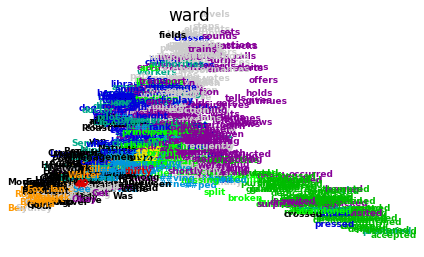

In [9]:
plot_clustering(X_red, clustering.labels_, 'ward')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


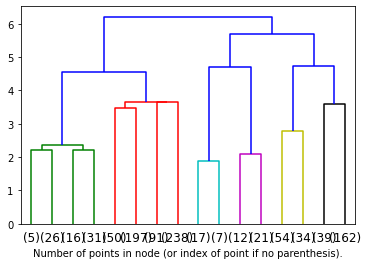

In [10]:
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [11]:
len(set(model.labels_))

14